In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

## Read data

In [ ]:
# Joseph Radmon's code for parsing images into CSV data with addition to generating labels as first csv row
# https://pjreddie.com/projects/mnist-in-csv/

def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)
        
    o.write("label,"+",".join(("pixel" + str(x)) for x in range(0,784))+"\n")
    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("./original_data/train-images.idx3-ubyte", "./original_data/train-labels.idx1-ubyte",
        "./data/mnist_train.csv", 60000)
convert("./original_data/t10k-images.idx3-ubyte", "./original_data/t10k-labels.idx1-ubyte",
        "./data/mnist_test.csv", 10000)

Reading training and testing data in csv format from the exported mnist_train.csv and mnist_test.csv using pandas.

In [2]:
training = pd.read_csv('./data/mnist_train.csv')
testing = pd.read_csv('./data/mnist_test.csv')
training.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Visualize data

Training dataset contains 60000 rows and 785 columns, out of which one is categorical.

In [3]:
training.shape

(60000, 785)

Testing dataset contains 10000 rows and 785 columns, structured in the same way as the training dataset.

In [4]:
testing.shape

(10000, 785)

There are no null values, which is expected since we generated the csv dataset out of ubyte data.

In [5]:
training.isnull().sum().sum()

0

In [6]:
training.describe(percentiles=[0,0.25,0.5,0.75,1])

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
0%,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
100%,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


Datasets we use to train our models have to be balanced to remove any bias towards any class.

Looking at the bar chart we can see that this dataset is fairly balanced. There is similar number of instances in each class.

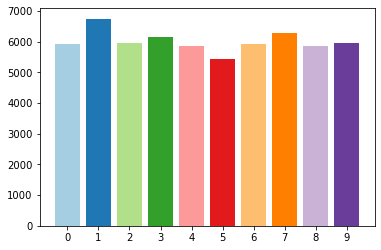

In [7]:
plot_series = training["label"].value_counts().sort_index()
plt.bar(range(len(plot_series)), plot_series, color=plt.cm.Paired(np.arange(len(plot_series))))
plt.xticks(range(10))
plt.show()

#### Visualize some instances

We can visualize some of the numbers using pyplot.imshow method.

Text(0.5, 1.0, 'Digit 1')

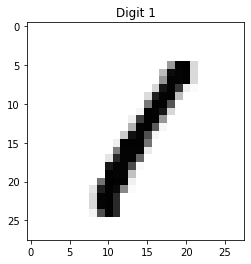

In [8]:
one = training.iloc[3, 1:]
one = one.values.reshape(28,28)
plt.imshow(one, cmap=plt.get_cmap("Greys"))
plt.title("Digit 1")

Text(0.5, 1.0, 'Digit 1')

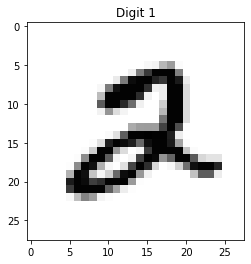

In [9]:
two = training.iloc[5, 1:]
two = two.values.reshape(28,28)
plt.imshow(two, cmap=plt.get_cmap("Greys"))
plt.title("Digit 1")

#### Visualize frequency of some pixels

Let's see how frequent different pixels are in different numbers/classes. Frequency in this context is simply number of occurances for the selected pixel, in other words, if that pixel isn't white in one concrete instance it counts as one occurance.

First we plot data for pixel 406 which is supposed to be in the middle of an image. As expected it is present in all 1s and almost no 0s.

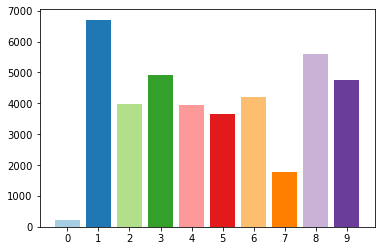

In [10]:
modified_training = training.copy(True).astype(bool)
modified_training["label"] = training["label"]
plot_series = modified_training.groupby("label").sum().sort_index()["pixel406"]
plt.bar(range(len(plot_series)), plot_series, color=plt.cm.Paired(np.arange(len(plot_series))))
plt.xticks(range(10))
plt.show()

Then we plot data for pixel 720 which is supposed to be in the bototm right corner of an image (28 * 20 + 20). As expected it is most common in 9s and least common in 0s, 1s and 6s.

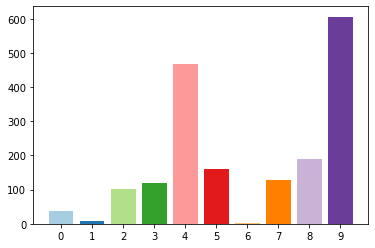

In [11]:
plot_series = modified_training.groupby("label").sum().sort_index()["pixel692"]
plt.bar(range(len(plot_series)), plot_series, color=plt.cm.Paired(np.arange(len(plot_series))))
plt.xticks(range(10))
plt.show()

## Model building

In [12]:
x_train = training.drop("label", axis=1)
y_train = training["label"]

x_test = testing.drop("label", axis=1)
y_test = testing["label"]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [13]:
# model_linear = SVC(kernel='linear')
# model_linear.fit(x_train, y_train)
# 
# y_pred = model_linear.predict(x_test)
# print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

Fatal mistake: used all 60000 instances to train. Took more than 12h and we are not waiting for it to complete, so we are dividing the dataset into smaller batches and training the SGDClassifier model in batches. Each batch contains 1000 instances.

In [14]:
sgd_model = SGDClassifier(loss="hinge", penalty="l2")
for i in range(0, 60):
        y_train_batch = y_train[i*1000 :(i + 1)* 1000]
        x_train_batch = x_train[i*1000 :(i + 1)* 1000]
        
        sgd_model.partial_fit(x_train_batch, y_train_batch, classes=range(10))

In [15]:
y_pred = sgd_model.predict(x_test)
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
print(metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

[[ 968    0    1    1    0    1    3    2    4    0]
 [   0 1118    1    2    1    1    4    0    7    1]
 [  44   58  740   63   13    3   39   10   58    4]
 [  28    2    7  840    2   61   12   11   30   17]
 [  13    2    4    1  834    0   26    2   14   86]
 [  31    6    5   19   14  664   28    9  100   16]
 [  18    4    0    0    2   25  899    1    8    1]
 [   6   18   23    7    6    0    2  916   11   39]
 [  20   50    3   20   25   24   16   14  770   32]
 [  19    5    5   11   24    5    7   23   14  896]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       980
           1       0.89      0.99      0.93      1135
           2       0.94      0.72      0.81      1032
           3       0.87      0.83      0.85      1010
           4       0.91      0.85      0.88       982
           5       0.85      0.74      0.79       892
           6       0.87      0.94      0.90       958
           7       0.93      0.89   

And now to try regular SVM on a smaller dataset.

In [16]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train[0:10000], y_train[0:10000])

y_pred = svm_model.predict(x_test)
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
print(metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

[[ 954    0    7    1    0    6    8    2    1    1]
 [   0 1120    1    2    0    2    3    1    6    0]
 [   8   10  930   11   10    4   13   12   32    2]
 [   3    2   28  905    2   24    2    9   26    9]
 [   2    1   12    0  931    0    6    5    2   23]
 [  12    6    6   61    8  752   15    1   25    6]
 [  12    3   12    1    9   13  906    0    1    1]
 [   3    9   22   14    8    0    0  938    5   29]
 [   7   19    9   40   11   33   11    6  828   10]
 [   8    7    2   16   57    6    1   49    4  859]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.95      0.99      0.97      1135
           2       0.90      0.90      0.90      1032
           3       0.86      0.90      0.88      1010
           4       0.90      0.95      0.92       982
           5       0.90      0.84      0.87       892
           6       0.94      0.95      0.94       958
           7       0.92      0.91   

Now to try SVM with non-linear RBF kernel.

In [17]:
rbf_model = SVC(kernel='rbf')
rbf_model.fit(x_train[0:10000], y_train[0:10000])

y_pred = rbf_model.predict(x_test)
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
print(metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

[[ 969    0    2    0    0    3    3    1    2    0]
 [   0 1123    3    2    0    1    3    1    2    0]
 [   7    0  989    5    7    0    4   10   10    0]
 [   1    1   13  963    0   10    1   11    9    1]
 [   1    0    3    0  946    0    6    1    2   23]
 [   6    1    3   19    2  840   12    1    6    2]
 [   7    3    1    0    5    3  937    0    2    0]
 [   0   13   20    4    7    0    0  971    1   12]
 [   4    1    5   12    6    6    4    5  926    5]
 [   8    7    2   11   28    2    0   14    7  930]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.97      0.94      0.96       892
           6       0.97      0.98      0.97       958
           7       0.96      0.94   

## Hyperparameter tuning

In [18]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
              'gamma': [5, 1, 0.1]}
 
grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, refit = True, verbose = 3, scoring= 'accuracy', n_jobs = -1)

grid.fit(x_train[0:10000], y_train[0:10000])

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
                         'gamma': [5, 1, 0.1]},
             scoring='accuracy', verbose=3)

In [19]:
print(grid.best_params_)

{'C': 0.001, 'gamma': 5}


In [20]:
y_pred = grid.predict(x_test)
print(metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000



D:\anaconda3\envs\test-env-10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\test-env-10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\test-env-10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now if we scale the dataset we should get some acceptable results.

In [21]:
scaled_training = scale(training)

# train size is 80% of 16.6667% data
x_train, x_test, y_train, y_test = train_test_split(scaled_training, training['label'], train_size=0.13334, test_size=0.03333, shuffle = True, random_state = 8)

# val size is 25% of 80% of 16.5557% which makes dis distribution 6-2-2 for train-val-test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state= 8)

print(x_train.shape)
print(y_test.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(6000, 785)
(2000,)
(2000, 785)
(2000,)
(2000, 785)
(2000,)


In [22]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
              'gamma': [5, 1, 0.1, 0.001, 0.0001]}
 
grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, refit = True, verbose = 3, scoring= 'f1_weighted', n_jobs = -1)

grid.fit(x_val, y_val)
print(grid.best_params_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
{'C': 10, 'gamma': 0.001}


In [23]:
y_pred = grid.predict(x_test)
print(metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       201
           1       0.97      0.99      0.98       234
           2       0.88      0.92      0.90       199
           3       0.95      0.88      0.92       199
           4       0.92      0.94      0.93       197
           5       0.92      0.91      0.92       188
           6       0.95      0.93      0.94       181
           7       0.89      0.91      0.90       210
           8       0.97      0.90      0.93       192
           9       0.91      0.94      0.93       199

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [24]:
new_rbf_model = SVC(kernel='rbf', C=10, gamma=0.001)
new_rbf_model.fit(x_train, y_train)

y_pred = new_rbf_model.predict(x_test)
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
print(metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

[[195   0   2   3   0   1   0   0   0   0]
 [  0 232   1   0   0   0   0   1   0   0]
 [  0   2 192   2   1   0   1   1   0   0]
 [  0   2   9 181   0   5   0   1   1   0]
 [  0   0   3   0 189   1   1   1   0   2]
 [  1   0   2   5   0 177   2   0   1   0]
 [  0   0   4   0   0   3 174   0   0   0]
 [  3   0   7   1   5   0   0 189   2   3]
 [  0   0   3   1   0   2   1   2 178   5]
 [  0   0   1   0   1   0   0   5   0 192]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       201
           1       0.98      0.99      0.99       234
           2       0.86      0.96      0.91       199
           3       0.94      0.91      0.92       199
           4       0.96      0.96      0.96       197
           5       0.94      0.94      0.94       188
           6       0.97      0.96      0.97       181
           7       0.94      0.90      0.92       210
           8       0.98      0.93      0.95       192
           9       0.95     